In [1]:
using JuMP, GLPKMathProgInterface

The following model shows how to calculate two models for scheduling call center agents given some (estimated) demand for customer calls or contacts for a given week. 

We differentiate between permanent employees and temporary call center employees that have different efficiencies, measured in calls per hour, as well cost (per hour).
- We estimate the overall labor requirements by type, and we also
- Estimate the requirements by type by day given a distribution of calls per day

We'll use the [JuMP package](https://github.com/JuliaOpt/JuMP.jl) to do the optimization calculation for us using integer programming and discrete optimization.

## Inputs

In [2]:
total_calls = 7000
hours_per_shift = 9

labor_types = ["perm"; "temp"]

# Minimum and maximum number of agents per type
min_agents = Dict("perm" => 10, "temp" => 0)
max_agents = Dict("perm" => 50, "temp" => 30)

# Efficiency assumptions
# We assume 5 calls per permanent agent and 3 per temp agent
calls_per_hour_per_agent = Dict("perm" => 5, "temp" => 3)

# The hourly cost in $ per agent per type 
cost_per_agent_hour = Dict("perm" => 20, "temp" => 10)

# # We assume agents work 5 day weeks 
# days_per_week = 5

# To simplify things, we calculate the number of calls an agent can handle per day 
calls_per_day_per_agent = Dict()
for labor_type in labor_types
   calls_per_day_per_agent[labor_type] = calls_per_hour_per_agent[labor_type] * hours_per_shift
end

In [3]:
calls_per_day_per_agent

Dict{Any,Any} with 2 entries:
  "temp" => 27
  "perm" => 45

## Model 1: Total Agent Mix

In [4]:
model = Model(solver=GLPKSolverMIP())

# We need an agent variable for each type of labor
@variable(model, agents[labor_types] >= 0, Int)

# We want to minimize the Labor Cost function
@objective(model, Min, sum(hours_per_shift * days_per_week * cost_per_agent_hour[t] * agents[t] for t in labor_types))

# Constraints

# Must satisfy total demand
@constraint(model, sum(agents[t] * calls_per_day_per_agent[t] * days_per_week for t in labor_types) >= total_calls)
# No more than N agents per type
@constraint(model, max_agent_constraint[t=labor_types], sum(agents[t]) <= max_agents[t])
# Minimum of N agents per type
@constraint(model, min_agent_constraint[t=labor_types], sum(agents[t]) >= min_agents[t])

model

Minimization problem with:
 * 5 linear constraints
 * 2 variables: 2 integer
Solver is GLPKInterfaceMIP

In [5]:
status = solve(model)

println("Objective value: ", getobjectivevalue(model))
println("Solution:  ", getvalue(agents))

Objective value: 25650.0
Solution:  agents: 1 dimensions:
[perm] = 14.0
[temp] = 29.0


So, based on our first model, we'll need 14 permanent and 29 temp employees to satisfy our call demand. Our total labor cost is $25,650.

We also want to know our total call capacity given this optimal number of agents: 

In [6]:
# Call Capacity:
calls_capacity = sum(calls_per_day_per_agent[t] * days_per_week * getvalue(agents[t]) for t in labor_types)

7065.0

Thus, with 14 permanent and 29 temp agents, we'll be able to handle 7,065 calls, less than 1% more than we needed.

## Model 2: Agent Mix By Weekday
Our second model breaks out the labor requirements by day, given a set of % of weekly volume for each day.

We start the week on Mondays and set the target %s for each weekday

In [7]:
# using DataFrames

In [159]:
weekdays = collect(1:7)
weekdays

7-element Array{Int64,1}:
 1
 2
 3
 4
 5
 6
 7

In [160]:
weekday_perc = [.20,.18,.16,.16, .12,.10,.08]
sum(weekday_perc)

1.0

In [161]:
# weekday_dist = Dict(zip(weekdays, weekday_perc))
# weekday_dist = DataFrame(weekday = weekdays, weekday_perc = weekday_perc)

Let's look at what this distribution looks like:

In [162]:
using PyPlot

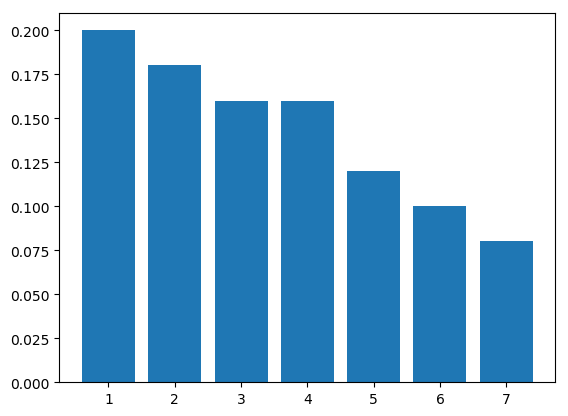

In [163]:
fig = figure("weekday_dist")
b = bar(weekdays, weekday_perc);

We create a dictionary that holds the total number of calls we need to support based on our total goal of 7,000 and our historic breakdown of calls per week day. 

In [164]:
weekday_totalcalls = Dict()
for d in weekdays
   weekday_totalcalls[d] = weekday_perc[d] * total_calls
end
weekday_totalcalls

Dict{Any,Any} with 7 entries:
  7 => 560.0
  4 => 1120.0
  2 => 1260.0
  3 => 1120.0
  5 => 840.0
  6 => 700.0
  1 => 1400.0

In [165]:
weekday_model = Model(solver=GLPKSolverMIP())

# We need an agent variable for each type of labor
@variable(weekday_model, agents[weekdays, labor_types] >= 0, Int)

# We want to minimize the Labor Cost function
@objective(weekday_model, Min, sum(hours_per_shift * cost_per_agent_hour[t] * agents[d, t] 
        for d in weekdays
            for t in labor_types))

# Must satisfy total demand
@constraint(weekday_model, sum(agents[d, t] * calls_per_day_per_agent[t] 
                        for d in weekdays
                            for t in labor_types) >= total_calls)

@constraint(weekday_model, min_demand_constraint[d=weekdays], 
                sum(agents[d, t] * calls_per_day_per_agent[t] 
                        for t in labor_types) >= weekday_totalcalls[d])

# We modify our min/max agent constraints a bit to make sure we have exactly two permanent employees staffed on weekends:
@constraint(weekday_model, min_agent_constraint[d=weekdays, t=labor_types], 
                agents[d, t] >= (d in (6,7) && t == "perm" ? 2 : min_agents[t]))
                                
@constraint(weekday_model, max_agent_constraint[d=weekdays, t=labor_types], 
                agents[d, t] <= (d in (6,7) && t == "perm" ? 2 : max_agents[t]))
                                
weekday_model

Minimization problem with:
 * 36 linear constraints
 * 14 variables: 14 integer
Solver is GLPKInterfaceMIP

In [166]:
status = solve(weekday_model)

println("Objective value: ", getobjectivevalue(weekday_model))
println("Solution:  ", getvalue(agents))

Objective value: 25290.0
Solution:  agents: 2 dimensions:
[1,:]
  [1,perm] = 14.0
  [1,temp] = 29.0
[2,:]
  [2,perm] = 10.0
  [2,temp] = 30.0
[3,:]
  [3,perm] = 10.0
  [3,temp] = 25.0
[4,:]
  [4,perm] = 10.0
  [4,temp] = 25.0
[5,:]
  [5,perm] = 11.0
  [5,temp] = 13.0
[6,:]
  [6,perm] = 2.0
  [6,temp] = 23.0
[7,:]
  [7,perm] = 2.0
  [7,temp] = 18.0


Our total labor cost is slightly lower at $25,290, likely b/c we shifted the weekend schedule towards more temp agents.

We'll convert the results to a dataframe and also calculate the total call capacity per day:

In [42]:
using DataFrames

In [168]:
df_solution = vcat([DataFrame(weekday=weekdays, labor_type=t,
                agents=[getvalue(agents[d, t]) for d in weekdays],
                call_capacity=[sum(getvalue(agents[d, t]) * calls_per_day_per_agent[t]) for d in weekdays]
                )
                for t in labor_types])

,weekday,labor_type,agents,call_capacity
1,1,perm,14.0,630.0
2,2,perm,10.0,450.0
3,3,perm,10.0,450.0
4,4,perm,10.0,450.0
5,5,perm,11.0,495.0
6,6,perm,2.0,90.0
7,7,perm,2.0,90.0
8,1,temp,29.0,783.0
9,2,temp,30.0,810.0
10,3,temp,25.0,675.0


From there, we can summarize the solution by weekday:

In [173]:
by(df_solution, :weekday, d -> DataFrame(agents=sum(d[:agents]), call_capacity=sum(d[:call_capacity])))

,weekday,agents,call_capacity
1,1,43.0,1413.0
2,2,40.0,1260.0
3,3,35.0,1125.0
4,4,35.0,1125.0
5,5,24.0,846.0
6,6,25.0,711.0
7,7,20.0,576.0


Or pivot the number of needed agents by labor type:

In [175]:
unstack(df_solution, :weekday, :labor_type, :agents)

,weekday,perm,temp
1,1,14.0,29.0
2,2,10.0,30.0
3,3,10.0,25.0
4,4,10.0,25.0
5,5,11.0,13.0
6,6,2.0,23.0
7,7,2.0,18.0


Or pivot call capacity by labor type:

In [176]:
unstack(df_solution, :weekday, :labor_type, :call_capacity)

,weekday,perm,temp
1,1,630.0,783.0
2,2,450.0,810.0
3,3,450.0,675.0
4,4,450.0,675.0
5,5,495.0,351.0
6,6,90.0,621.0
7,7,90.0,486.0
